In [ ]:
# assume: "images.zip" already is uploaded
# note: the "images.zip" is obtained via AllenSDK by Lisa
# note: unsure whether the names/IDs/orders of the images are stable across experiments

# the following creates a folder and unzips them
!mkdir -p images
!unzip images.zip -d images

In [ ]:
%pip install timm

## Compute features

In [ ]:
import os
import glob
import re
from natsort import natsorted
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from matplotlib import pyplot as plt

In [ ]:
# change "image_dir" to where you store the images

image_dir = "images"
image_files = natsorted(glob.glob(os.path.join(image_dir, '*.png')))
print(f'There are {len(image_files)} images')

There are 118 images


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, files, transform):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # a bit hacky: these are gray-scale images but use PIL to convert to RGB
        image = Image.open(self.files[idx]).convert('RGB')
        image = self.transform(image)
        return image

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageDataset(
    files = image_files,
    transform = preprocess
)

dataloader = DataLoader(
    dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 2
)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [ ]:
model = timm.create_model(
    model_name = 'resnet18', # change to other models to see what changes
    features_only = True,
    pretrained = True
)
model.to(device)


FeatureListNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=

In [ ]:
model.feature_info.module_name()

['act1', 'layer1', 'layer2', 'layer3', 'layer4']

In [ ]:
modules = model.feature_info.module_name()
features = {m: [] for m in modules}

for i, inputs in enumerate(dataloader):
    inputs = inputs.to(device)
    for j, feat in enumerate(model(inputs)):
        features[modules[j]].append(feat)

In [ ]:
features.keys()

dict_keys(['act1', 'layer1', 'layer2', 'layer3', 'layer4'])

In [ ]:
vectorized_features = dict()

for m, feat in features.items():
    vectorized_features[m] = (
        torch.vstack(feat)
        .sum(axis=1)
        .detach()
        .cpu()
        .flatten(start_dim=1)
    )
    print(f'Shape of "{m}" is: {vectorized_features[m].shape}')

Shape of "act1" is: torch.Size([118, 12544])
Shape of "layer1" is: torch.Size([118, 3136])
Shape of "layer2" is: torch.Size([118, 784])
Shape of "layer3" is: torch.Size([118, 196])
Shape of "layer4" is: torch.Size([118, 49])


You can use these vectorized versions to do whatever you want, like comparing between them (e.g. cosine distances) or put them in a low-dimensional embedding

## Visualize on low-dim embedding

Below is an example to use features from `layer1` and visualize using tSNE.

Change to other layers/modules (see above) and change to other types of embedding (PCA, MDS, UMAP, ...).

Change to other models (e.g. `resnet50`)

and see what's appropriate for the data and for your task

In [ ]:
from sklearn.manifold import TSNE
X = vectorized_features['layer1']

embedder = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    perplexity=3,
    random_state=28435, # set this for reproducibility
)

X_embed = embedder.fit_transform(X)

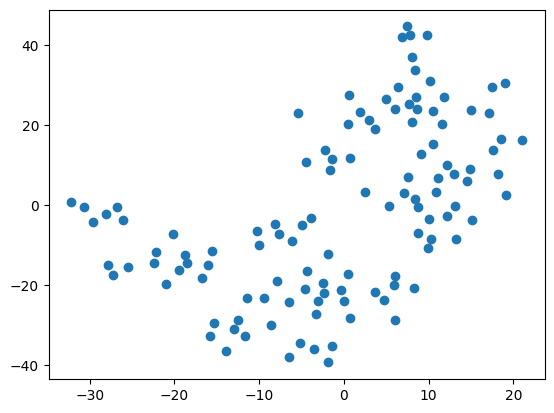

In [ ]:
# plot as scatter
plt.scatter(X_embed[:,0],X_embed[:,1])

Below we'll overlay the actual original images (with lower resolution) with the same positions as above

In [ ]:
import bokeh
from bokeh.plotting import figure, show
from bokeh.models import BoxZoomTool

bokeh.io.output_notebook()

p = figure(width=1200, height=800, match_aspect=True, tools="pan,wheel_zoom,save,reset")
p.add_tools(BoxZoomTool(match_aspect=True))

basewidth = 50

resized_images = []
for img_file in image_files:
    img = Image.open(img_file)
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), Image.Resampling.LANCZOS)
    img = np.flipud(np.array(img))
    resized_images.append(img)

p.image(
    image = resized_images,
    x = X_embed[:,0],
    y = X_embed[:,1],
    dw=3, # dw and dh makes sure they don't overlap too much
    dh=3,
    palette="Greys256",
    level="image"
)

show(p)

## Cosine similarity

Below we're examining the cosine similarity between the vectors from `layer4`

In [ ]:
from sklearn.metrics.pairwise import (
    cosine_similarity,
    cosine_distances
)
import seaborn as sns

X = vectorized_features['layer4']
sX = cosine_similarity(X)
dX = cosine_distances(X) # this is basically 1 - sX

In [ ]:
sX.shape

(118, 118)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


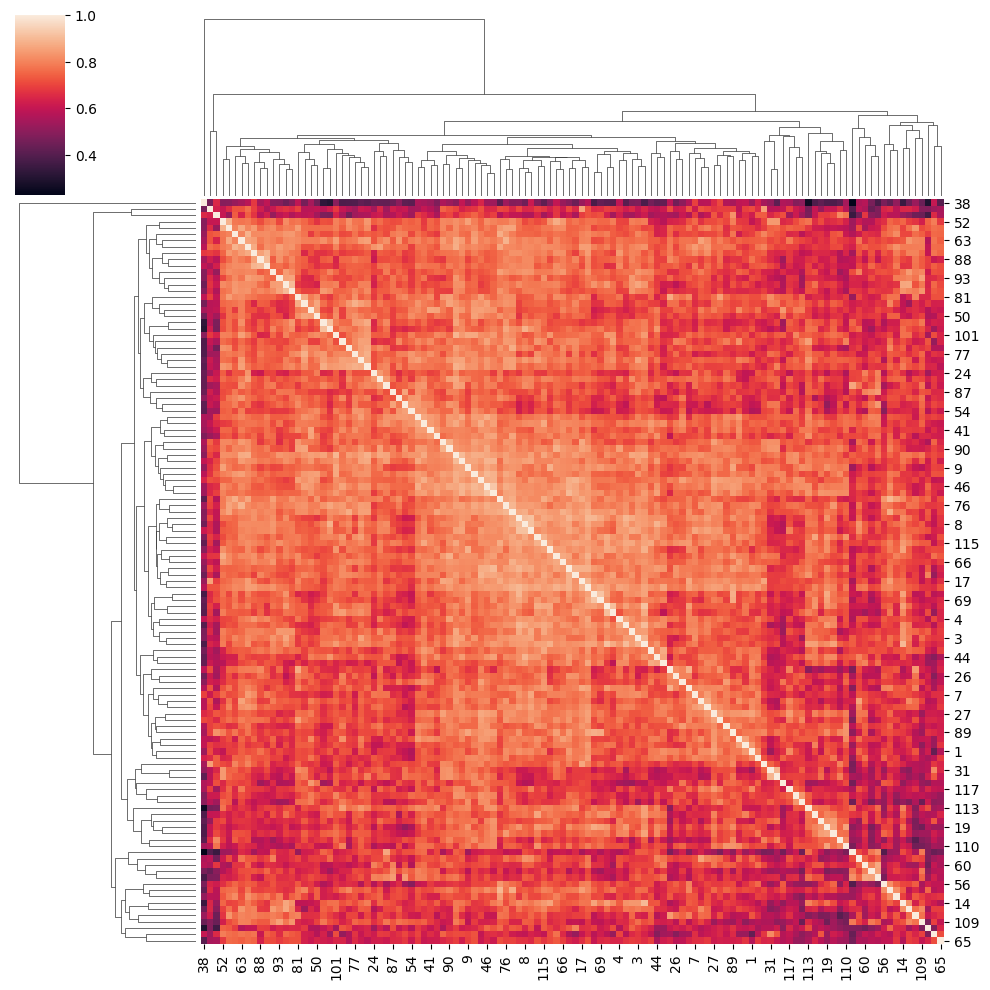

In [ ]:
sns.clustermap(sX)